In [1]:
import galprime
galprime.plotting.pyplot_style()
cmap = galprime.plotting.lavender_cmap()

from astropy.io import fits
from astropy.table import Table
from astropy.modeling.models import Sersic2D

import configobj

import numpy as np

from scipy.special import gamma

from matplotlib import pyplot as plt

from astropy.visualization import ZScaleInterval

from photutils.background import Background2D

In [20]:
class GPrime:

    def __init__(self, config_filename, verbose=True, **kwargs):
        self.config = galprime.read_config_file(config_filename)

        c = self.config

        # Load in all necessary files (backgrounds, psfs, catalogues, etc)
        self.bgs = galprime.Cutouts.from_file(c["FILE_DIR"] + c["FILES"]["BACKGROUNDS"], verbose=verbose)
        
        self.psfs = galprime.Cutouts.from_file(f'{c["FILE_DIR"]}{c["FILES"]["PSFS"]}', verbose=verbose)
        self.psfs.get_ra_dec(ra_key=c["PSF_INFO"]["PSF_RA"], dec_key=c["PSF_INFO"]["PSF_DEC"])
        
        self.table = Table.read(f'{c["FILE_DIR"]}{c["FILES"]["CATALOGUE"]}')
        self.table = galprime.trim_table(self.table, c)
        
        if c["FILES"]["MAG_CATALOGUE"] is not None:
            self.mags = Table.read(f'{c["FILE_DIR"]}{c["FILES"]["MAG_CATALOGUE"]}')
            self.mag_kde = galprime.object_kde(self.mags[c["KEYS"]["MAG"]])
        else:
            self.mags = self.mag_kde = None


    def run(self, max_bins=None, verbose=True):
        c = self.config
        for key in c["BINS"]:
            c["BINS"][key] = np.array(c["BINS"][key]).astype(float)
        
        binlist = galprime.bin_catalogue(self.table, bin_params=c["BINS"], params=c["KEYS"], verbose=True)

        for i, b in enumerate(binlist.bins):
            kde = b.to_kde()
            # Generate the GalPRIME containers
            # Run them through multithreading
            models = galprime.gen_models(c, kde, mag_kde=self.mag_kde, n_models=1)
            return b


test = GPrime("myconfig.gprime", verbose=True)
b_test = test.run()

Loaded 50 cutouts from ../pdata/cutouts_i.fits with shape (451, 451)
Loaded 5800 cutouts from ../pdata/i_psfs.fits with shape (41, 41)
Pruned 0 bins with fewer than 10 objects.


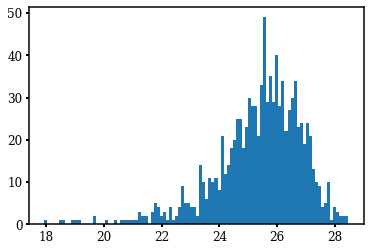

Loaded 50 cutouts from ../pdata/cutouts_i.fits with shape (451, 451)
50


/Users/hsouch/GalPRIME/galprime/plotting/general_plots.py:30: RuntimeWarning: invalid value encountered in log10
  cutout = np.log10(cutout)


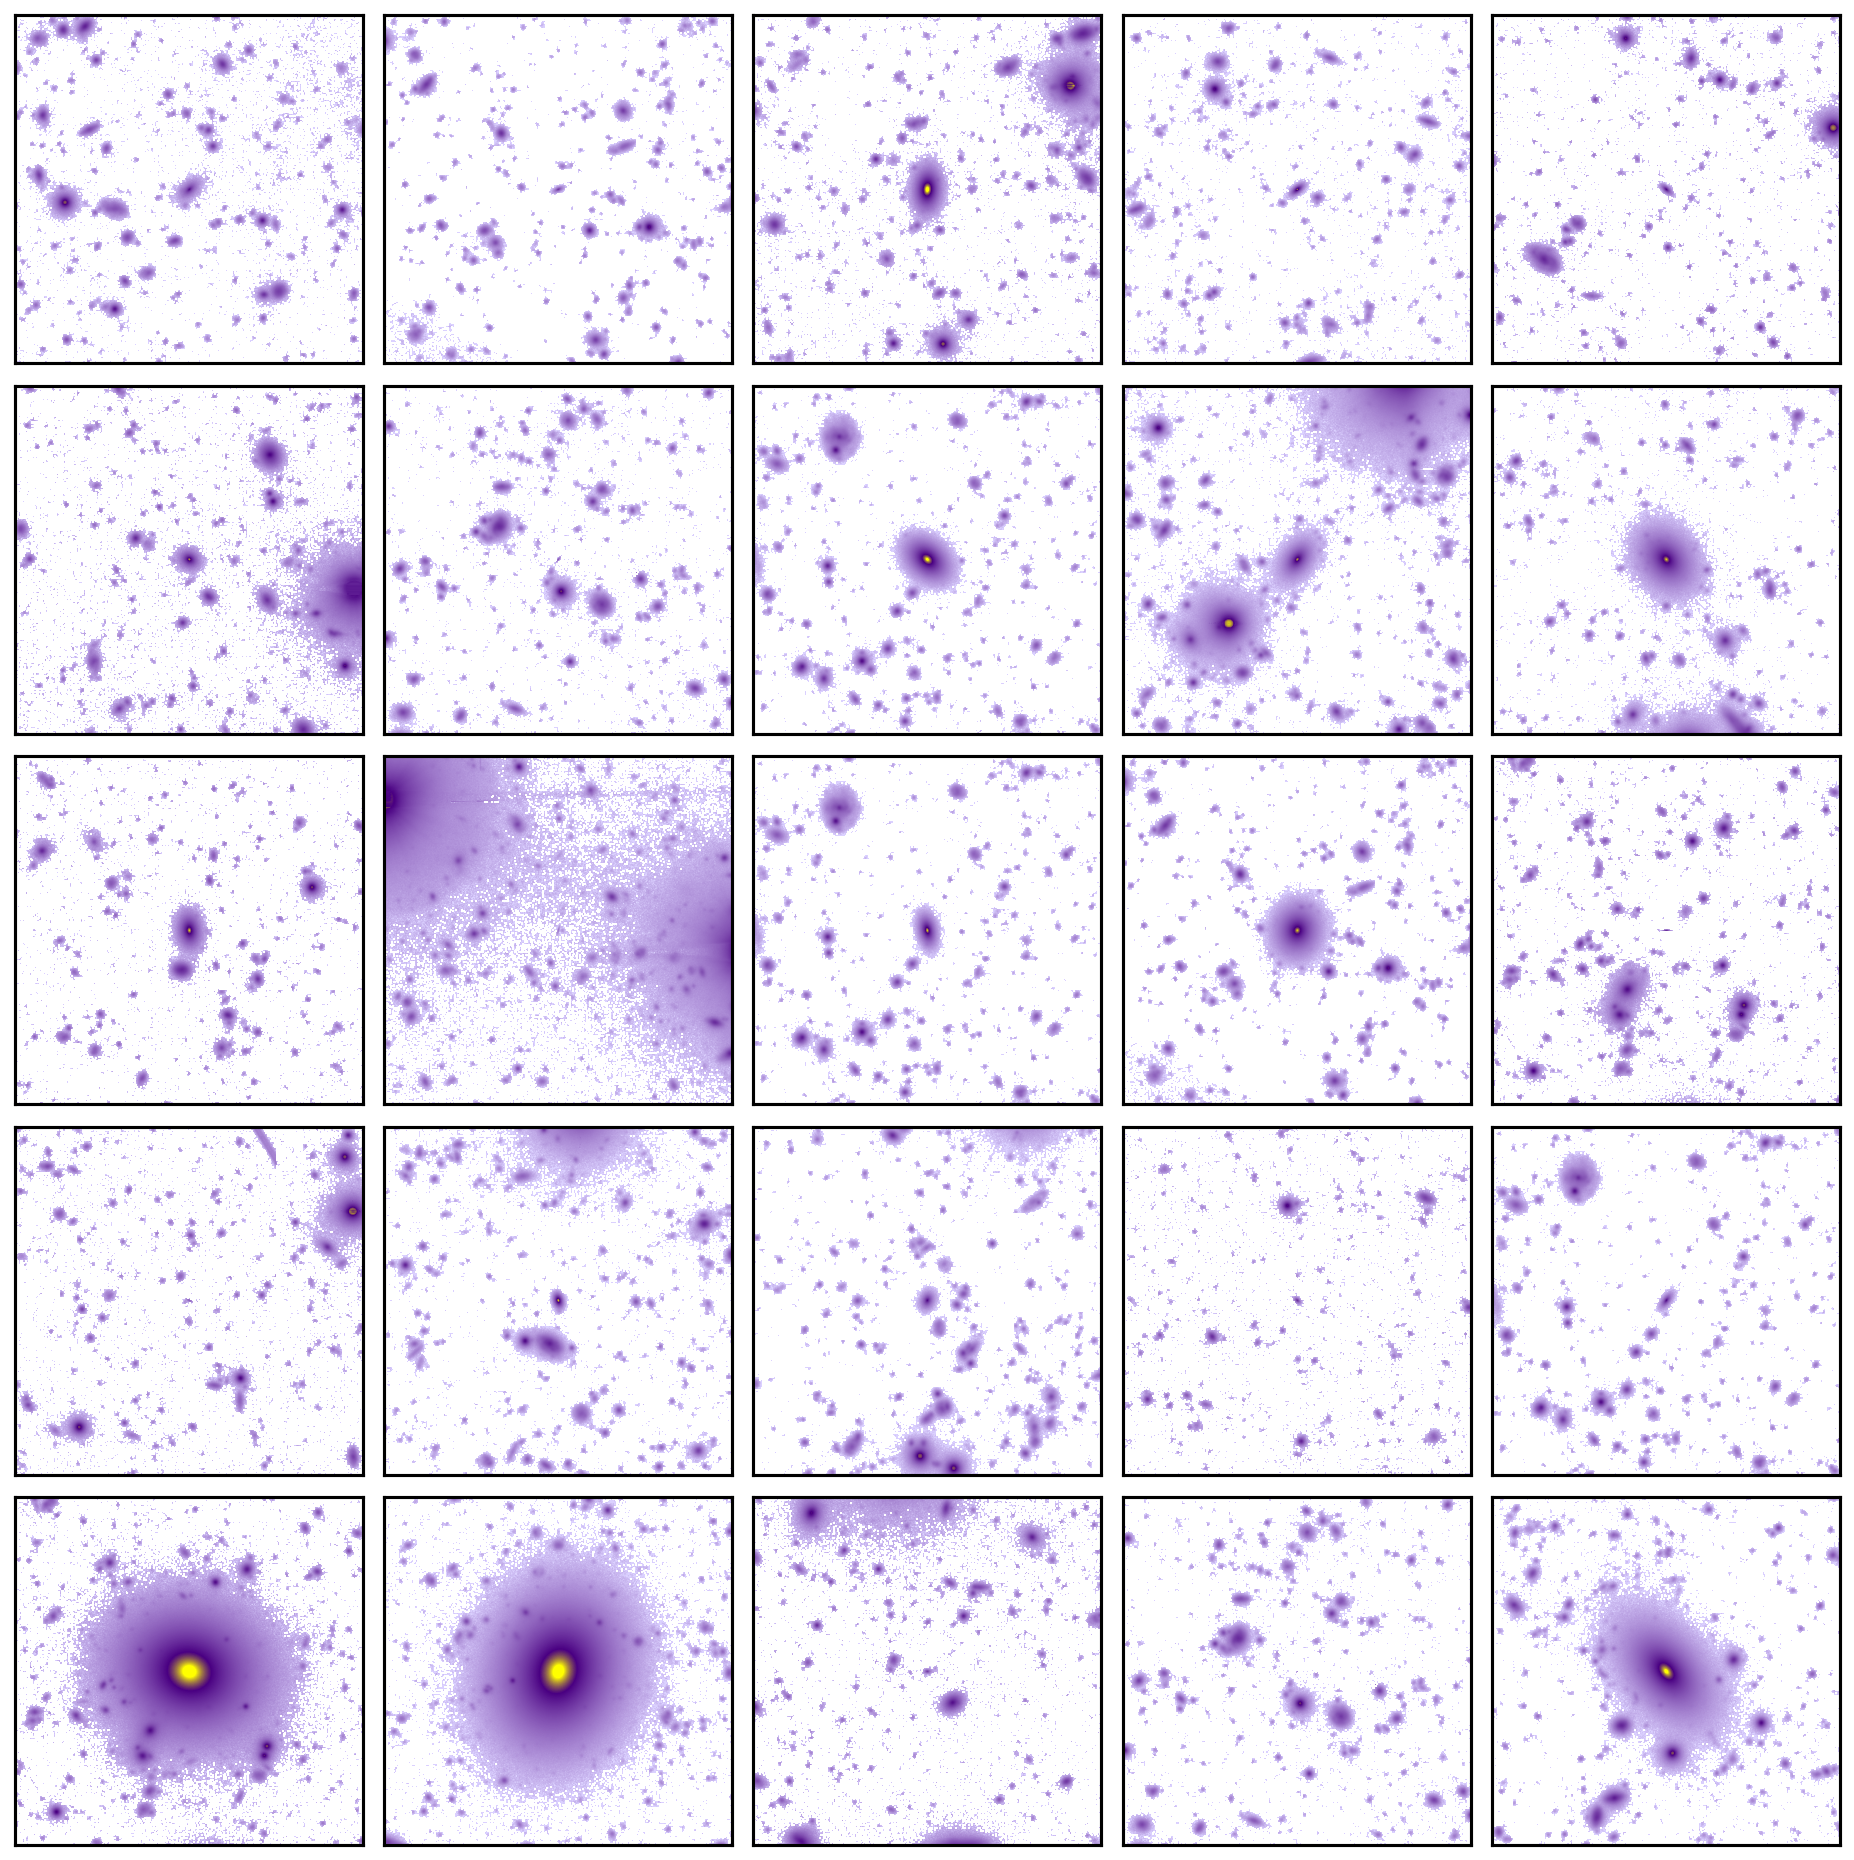

In [19]:
c = galprime.read_config_file("myconfig.gprime")

if c["FILES"]["MAG_CATALOGUE"] is not None:
    mags = Table.read(f'{c["FILE_DIR"]}{c["FILES"]["MAG_CATALOGUE"]}')
    mags = mags[c["KEYS"]["MAG"]]
    mags = mags[mags > 0]

    mag_kde = galprime.object_kde(mags)
else:
    mags = mag_kde = None

mags_test = mag_kde.resample(size=1000).T

plt.hist(mags_test.flatten(), bins=100)
plt.show()

models = galprime.gen_models(test.config, b_test.to_kde(), n_models=50, mag_kde=mag_kde)
bgs = galprime.Cutouts.from_file(c["FILE_DIR"] + c["FILES"]["BACKGROUNDS"], verbose=True)

for i, mod in enumerate(models.cutouts):
    models.cutouts[i] += bgs.sample()[0]

galprime.plotting.show_cutouts(models, cmap=cmap, method="log", vmin=-2, vmax=3)
plt.show()

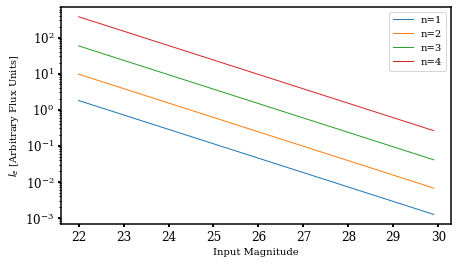

In [4]:

mags = np.arange(22, 30, 0.1)

plt.figure(figsize=(7, 4))

for n in [1, 2, 3, 4]:
    plt.plot(mags, galprime.I_e(mags, 5, n), label=f"n={n}")

plt.xlabel("Input Magnitude")
plt.ylabel(r"$I_e$" + f' [Arbitrary Flux Units]')
plt.yscale("log")
plt.legend()
plt.show()

